# 3d CNN volume classification

Os experimentos serão divididos em 


* Atividade PEL219 - GLWT CNN3D MedMNIST - Gabriel Melo. Matrícula: 125.304-6

In [21]:
import numpy as np
import seaborn as sns
import pandas as pd

from medmnist import NoduleMNIST3D
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Conv3D, MaxPooling3D, Dropout, BatchNormalization, Input, GlobalAveragePooling3D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

# Classification with Nodule from MedMNIST3D

Utilizei o dataset de Nodulos devido ao seu tamanho reduzido.

In [2]:
# Download latest version
train, test = NoduleMNIST3D(split="train", download=True), NoduleMNIST3D(split="test", download=True)

In [3]:
train.imgs.shape, train.labels.shape, test.imgs.shape, test.labels.shape

((1158, 28, 28, 28), (1158, 1), (310, 28, 28, 28), (310, 1))

In [4]:
y_train = to_categorical(train.labels)

In [ ]:
def train_glwt(model: Sequential, X: np.array, Y: np.array, optimizer="adam", loss="categorical_crossentropy", metrics="categorical_accuracy", _epochs=20, _validation_split=.1, _callbacks=None):
    histories = []
    
    for i in range(1, len(model.layers)):
        for layer in model.layers[:i]:
            layer.trainable = False
        for layer in model.layers[i:]:
            layer.trainable = True

        model.compile(optimizer, loss, metrics=[metrics])
        
        if not _callbacks:
            histories.append(model.fit(x=X, y=Y, epochs=_epochs, validation_split=_validation_split))
        else:
            histories.append(model.fit(x=X, y=Y, epochs=_epochs, validation_split=_validation_split, callbacks=_callbacks))
            
    return histories

# Definição do Modelo

Arquitetura ligeiramente reduzida, muitos parametros e dificuldade para treinar sem GPU (via colab)

In [6]:
input_layer = Input((train.imgs.shape[1], train.imgs.shape[2], train.imgs.shape[3], 1))

x = Conv3D(filters=64, kernel_size=(5, 5, 5), activation="relu", padding="same")(input_layer)
x = MaxPooling3D(pool_size=(5, 5, 5), padding="same")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Conv3D(filters=32, kernel_size=(3, 3, 3), activation="relu", padding="same")(x)
x = MaxPooling3D(pool_size=(3, 3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = GlobalAveragePooling3D()(x)
x = Dense(96, activation="relu")(x)
x = Dropout(0.3)(x)

output_layer = Dense(y_train.shape[1], activation="softmax")(x)  # digit numbers

model = Model(input_layer, output_layer, name="cnn3d")
model.summary()

2025-12-06 15:48:02.227905: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "cnn3d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 28, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 28, 28, 28, 64) │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 6, 6, 6, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6, 6, 6, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 6, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 6, 6, 6, 32)    │        55,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 2, 2, 2, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 2, 2, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 2, 2, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 96)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,138 (262.26 KB)

 Trainable params: 66,946 (261.51 KB)

 Non-trainable params: 192 (768.00 B)

# Training

Treinamento via GLW supervised pre-training + fine-tuning

In [7]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

hist = train_glwt(model, train.imgs, y_train, _callbacks=[es])

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - categorical_accuracy: 0.7486 - loss: 0.5541 - val_categorical_accuracy: 0.7672 - val_loss: 0.9889
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - categorical_accuracy: 0.7841 - loss: 0.4756 - val_categorical_accuracy: 0.7328 - val_loss: 0.4810
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - categorical_accuracy: 0.7985 - loss: 0.4634 - val_categorical_accuracy: 0.7759 - val_loss: 0.5359
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - categorical_accuracy: 0.8321 - loss: 0.4262 - val_categorical_accuracy: 0.8017 - val_loss: 0.4952
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - categorical_accuracy: 0.8340 - loss: 0.4007 - val_categorical_accuracy: 0.7845 - val_loss: 0.3931
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - categorical_accuracy: 0.8397 - loss: 0.4122 - val_categorical_accuracy: 0.7845 - val_loss: 0.5658
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - categorical_accuracy: 0.8541 - loss: 0.3755 - va

In [15]:
for layer in model.layers:
    layer.trainable = True

model.compile("adam", "categorical_crossentropy", metrics=["categorical_accuracy"])

model.fit(x=train.imgs, y=y_train, epochs=10, validation_split=.1, callbacks=[es])

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - categorical_accuracy: 0.8839 - loss: 0.2789 - val_categorical_accuracy: 0.6379 - val_loss: 1.4717
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - categorical_accuracy: 0.8916 - loss: 0.2647 - val_categorical_accuracy: 0.7414 - val_loss: 0.6043
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - categorical_accuracy: 0.9232 - loss: 0.1969 - val_categorical_accuracy: 0.8448 - val_loss: 0.4989
Epoch 3: early stopping


## Testing

Métricas padrão, nota-se que o dataset é desbalanceado, ~26% das amostras são nódulos malignos.

In [16]:
results = model.predict(test.imgs)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step


In [17]:
results_class = np.argmax(results, axis=1)

In [19]:
print(classification_report(test.labels, results_class))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       246
           1       0.68      0.62      0.65        64

    accuracy                           0.86       310
   macro avg       0.79      0.77      0.78       310
weighted avg       0.86      0.86      0.86       310



<Axes: >

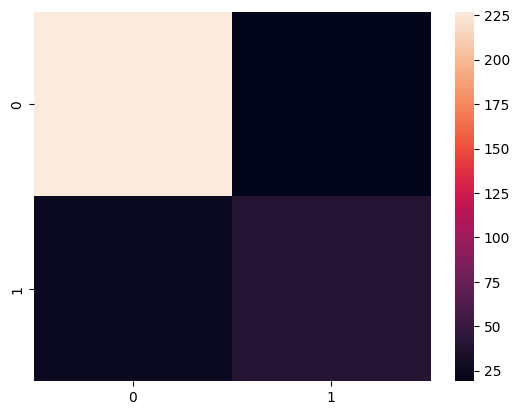

In [20]:
sns.heatmap(confusion_matrix(test.labels, results_class))

## Training data (Displaying only the last layer)

In [13]:
hist = [h.history for h in hist]

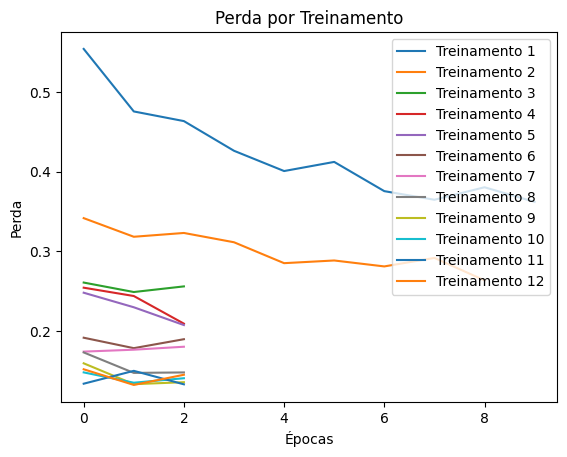

In [14]:
fig = plt.subplot(1,1,1)
for i, h in enumerate(hist):
    fig.plot(h['loss'], label=f'Treinamento {i+1}')
        
plt.title("Perda por Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Perda")
plt.legend()

plt.show()